In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

dde.config.set_random_seed(1234)

Using backend: tensorflow.compat.v1

2023-09-01 11:55:24.019374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


2023-09-01 11:55:33.779910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-01 11:55:34.195965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-01 11:55:34.196375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Enable just-in-time compilation with XLA.




In [2]:
num_dense_layers = 5
num_dense_nodes = 150
iterations = 10000
activation = 'tanh'
weights = 100

In [3]:
nx_train = 32 ** 2
nx_test = 100 ** 2

In [4]:
L = 2
n_max = 5

In [5]:
def pde(x, y):
    n = x[:, 1:2]
    k = (n * np.pi) / L
    E = 0.5 * (k ** 2)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return 0.5 * dy_xx + E * y

In [6]:
def psi(x):
    normalization_constant = np.sqrt(2.0 / L)
    n = x[:, 1:2]
    k = (n * np.pi) / L
    return normalization_constant * np.sin(k * (x[:, 0:1] + (L / 2)))

In [7]:
def x_boundary(x, on_boundary):
    if x[1].is_integer():
        return np.isclose(-L / 2, x[0]) or np.isclose(L / 2, x[0])
    return False

In [8]:
def get_collocation_points(n_max):
    points = []
    for n in range(1, n_max + 1):
        for k in range(n):
            x = (k * L) / n + L / (2 * n) - L / 2
            points.append((x, n))
            
        if n == 1:
            points.append((L / 4, n))
            points.append((-L / 4, n))
    
    return np.array(points)

In [9]:
domain = dde.geometry.Rectangle([-L / 2, 1], [L / 2, n_max])

In [10]:
collocation_points = get_collocation_points(n_max)
collocation_values = psi(collocation_points)
ic = dde.icbc.PointSetBC(collocation_points, collocation_values)

In [11]:
bc = dde.icbc.DirichletBC(domain, lambda x: 0, x_boundary)

In [12]:
data = dde.data.PDE(
    domain, 
    pde, 
    [ic, bc], 
    num_domain=nx_train,
    num_boundary=n_max * 2,
    solution=psi, 
    num_test=nx_test
)

In [13]:
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1],
    activation,
    'Glorot uniform'
)

In [14]:
model = dde.Model(data, net)

loss_weights = [1, weights, weights]
model.compile(
    'L-BFGS',
    metrics=['l2 relative error'],
    loss_weights=loss_weights
)


Compiling model...
Building feed-forward neural network...


/home/piotr/repos/quant-chem-pinns/venv/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.292910 s



2023-05-29 17:22:18.411110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 17:22:18.411596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 17:22:18.411967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'compile' took 11.676618 s



In [15]:
loss_history, train_state = model.train(iterations=iterations)

Initializing variables...


2023-05-29 17:22:43.818623: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...



2023-05-29 17:22:44.920039: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f8898009e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-29 17:22:44.920167: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce 940MX, Compute Capability 5.0
2023-05-29 17:22:45.732990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-29 17:23:00.088789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-29 17:23:13.715705: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                        Test loss                         Test metric   
0         [4.76e+00, 1.02e+02, 3.50e+00]    [4.71e+00, 1.02e+02, 3.50e+00]    [1.05e+00]    
1000      [9.35e-02, 2.33e-03, 2.27e-04]    [9.35e-02, 2.33e-03, 2.27e-04]                  
2000      [3.75e-03, 8.21e-05, 2.58e-07]    [3.75e-03, 8.21e-05, 2.58e-07]                  
3000      [7.78e-04, 2.07e-05, 2.22e-07]    [7.78e-04, 2.07e-05, 2.22e-07]                  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000541
  Number of iterations: 2958
  Number of functions evaluations: 3304
3304      [5.36e-04, 4.33e-06, 1.88e-08]    [5.56e-04, 4.33e-06, 1.88e-08]    [3.54e-02]    

Best model at step 3304:
  train loss: 5.41e-04
  test loss: 5.61e-04
  test metric: [3.54e-02]

'train' took 540.209530 s



Saving loss history to /home/piotr/repos/quant-chem-pinns/potential-well/1d/linear/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/potential-well/1d/linear/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/potential-well/1d/linear/test.dat ...


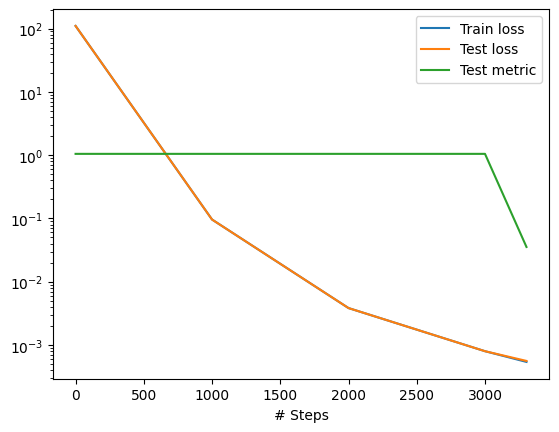

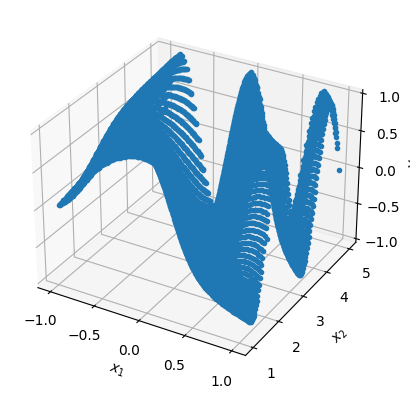

In [16]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

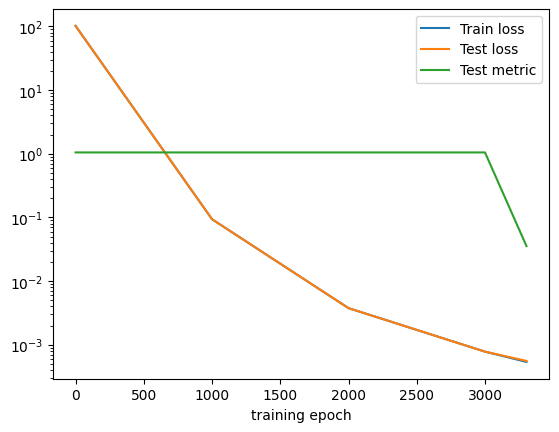

In [19]:
def save_loss_plot():
    loss_file = open('loss.dat', 'r')
    
    loss_file.readline()
    steps = []
    train_loss = []
    test_loss = []
    test_metric = []
    
    for line in loss_file:
        line = line.split()
        steps.append(float(line[0]))
        train_loss.append(max([float(line[i]) for i in range(1, 4)]))
        test_loss.append(max([float(line[i]) for i in range(4, 7)]))
        test_metric.append(float(line[-1]))
    
    loss_file.close()
    
    plt.plot(steps, train_loss, label='Train loss')
    plt.plot(steps, test_loss, label='Test loss')
    plt.plot(steps, test_metric, label='Test metric')
    
    plt.xlabel('training epoch')
    plt.yscale('log')
    
    plt.legend()
    plt.savefig('loss.png')
    plt.show()

save_loss_plot()

In [20]:
def predict_for_n(points):
    prediction = model.predict(points)
    return np.array(prediction)

In [37]:
def plot_results_for_n(n, num_points=10):
    x = np.linspace(-L / 2, L / 2, num=num_points)
    points = np.array([[i, n] for i in x])
    y_pred = predict_for_n(points)
    y_true = psi(points)
    
    plt.plot(x, y_true, 'o', color='black', label='Testing points')
    plt.plot(x, y_true, '-', color='black', label='True values')
    plt.plot(x, y_pred, '--', color='red', label='Predicted values')
    
    plt.xlabel('x')
    plt.ylabel('$\psi_{}$(x)'.format(n))
    
    plt.legend()
    plt.savefig('{}-results.png'.format(n))
    plt.show()
    
    error = dde.metrics.l2_relative_error(y_true, y_pred)
    print('L2 relative error for n = {}: {:.2e}'.format(n, error))

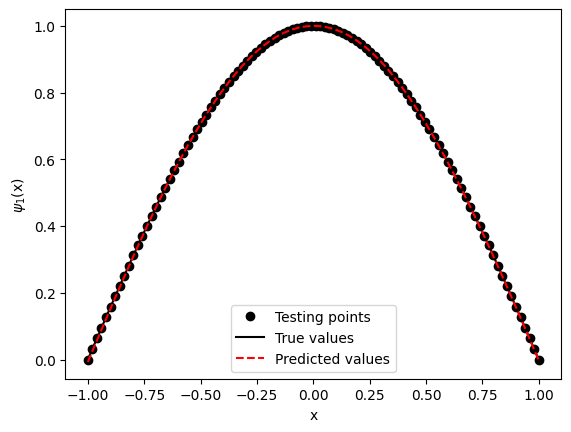

L2 relative error for n = 1: 2.81e-03


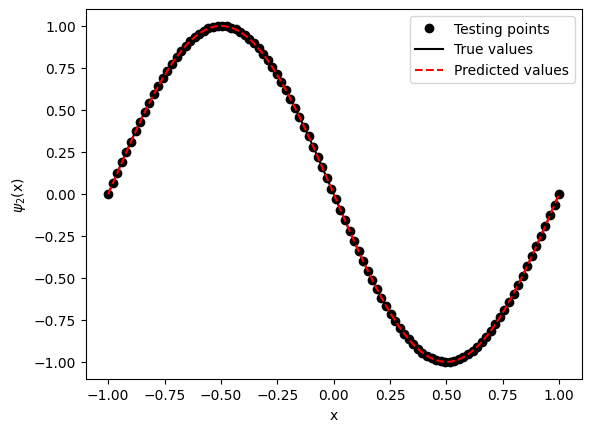

L2 relative error for n = 2: 1.02e-03


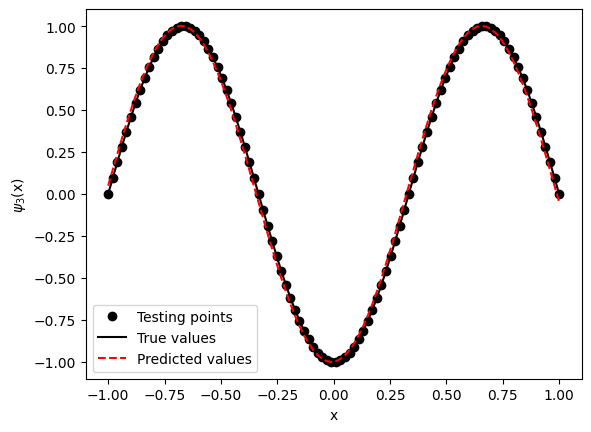

L2 relative error for n = 3: 4.85e-02


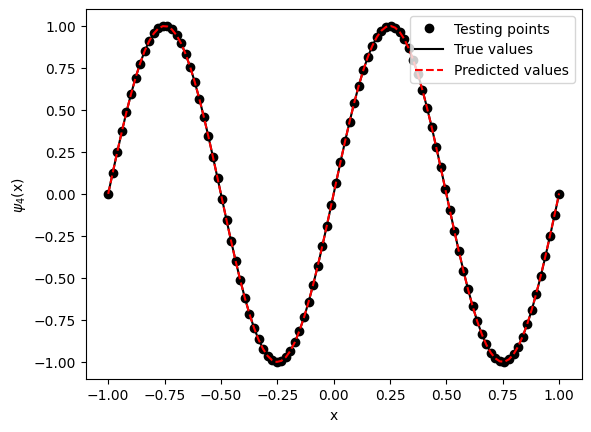

L2 relative error for n = 4: 1.40e-03


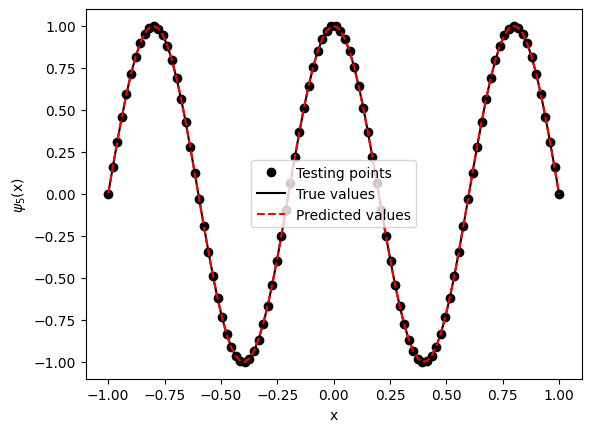

L2 relative error for n = 5: 2.64e-03


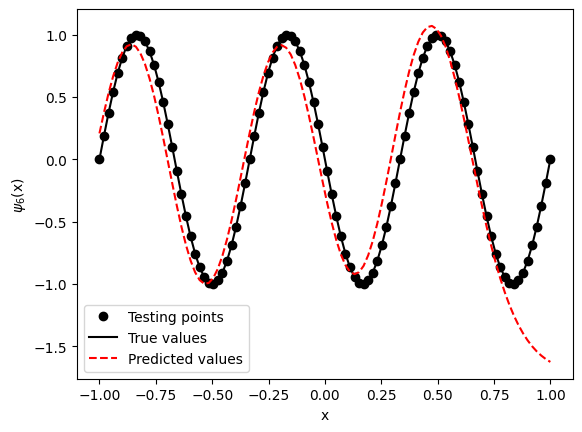

L2 relative error for n = 6: 4.94e-01


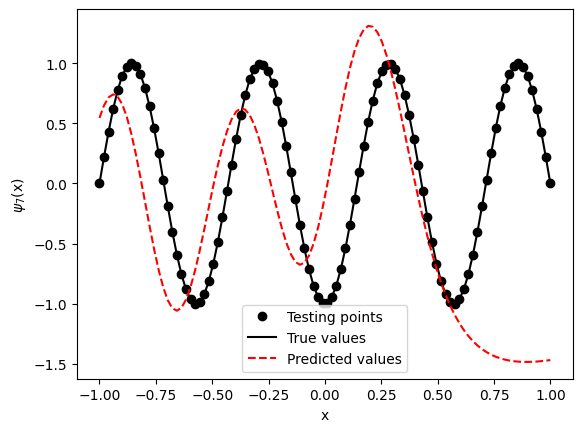

L2 relative error for n = 7: 1.43e+00


In [38]:
for i in range(1, 8):
    plot_results_for_n(i, num_points=100)